In [1]:
import numpy as np

import pennylane as qml
from pennylane import numpy as pnp
from qiskit.providers.aer.noise import NoiseModel
from qiskit_ibm_provider import IBMProvider
import qiskit

import os
import matplotlib.pyplot as plt

In [19]:
def HEA_circuit(params_data, params_ancilla):
    paulis = [qml.Identity, qml.PauliX, qml.PauliY, qml.PauliZ]
    time, depth, _ = params_data.shape
    time -= 2  # ignore data qubit
    for t in range(time):
        for l in range(depth):
            qml.RY(params_data[t, l, 0], wires=0)
            qml.RZ(params_data[t, l, 1], wires=0)
            qml.RY(params_data[t, l, 2], wires=1)
            qml.RZ(params_data[t, l, 3], wires=1)
            qml.RY(params_ancilla[t, l, 0], wires=t + 2)
            qml.RZ(params_ancilla[t, l, 1], wires=t + 2)

            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[1, t + 2])

    return [qml.expval(p(0) @ q(1)) for p in paulis for q in paulis]

In [32]:
T = 1
n_wires = T+2
depth = 5

dev_shot = qml.device('default.qubit', wires=n_wires, shots=1000)
HEA_expect_shot = qml.QNode(HEA_circuit, dev_shot)

np.random.seed(22)
weights_data = np.random.uniform(0, 4. * np.pi, (n_wires, depth, 4))
weights_ancilla = np.random.uniform(0, 4. * np.pi, (n_wires, depth, 2))

res_shot = HEA_expect_shot(weights_data, weights_ancilla)

In [6]:
with open('IBMQ_token_usc.txt', 'r') as f:
    TOKEN = f.read().strip()
#IBMProvider.save_account(token=TOKEN)
provider = IBMProvider()

In [33]:
T = 1
n_wires = T+2
depth = 5


backend = provider.get_backend('ibm_brisbane')
noise_model = NoiseModel.from_backend(backend)
dev_aer_noise = qml.device("qiskit.aer", wires=n_wires, noise_model=noise_model, shots=1000)
HEA_expect_noise = qml.QNode(HEA_circuit, dev_aer_noise)

np.random.seed(22)
weights_data = np.random.uniform(0, 4. * np.pi, (n_wires, depth, 4))
weights_ancilla = np.random.uniform(0, 4. * np.pi, (n_wires, depth, 2))

res_noise = HEA_expect_noise(weights_data, weights_ancilla)

In [ ]:
T = 1
n_wires = T+2
depth = 5

dev_ibmq = qml.device('qiskit.ibmq', wires=n_wires, backend='ibm_brisbane', shots=1000, provider=provider)
HEA_expect_ibmq = qml.QNode(HEA_circuit, dev_ibmq)

np.random.seed(22)
weights_data = np.random.uniform(0, 4. * np.pi, (n_wires, depth, 4))
weights_ancilla = np.random.uniform(0, 4. * np.pi, (n_wires, depth, 2))

res_exp = HEA_expect_ibmq(weights_data, weights_ancilla)

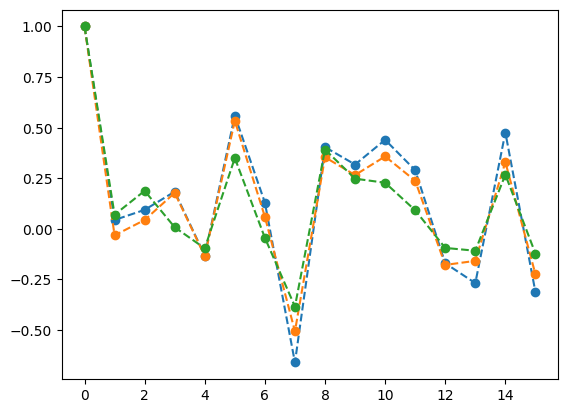

In [39]:
plt.plot(res_shot, 'o--', label='ideal')
plt.plot(res_noise, 'o--', label='noise simu')
plt.plot(res_exp, 'o--', label='exp')

In [38]:
np.sum(np.array(res_shot)**2)/4, np.sum(np.array(res_noise)**2)/4, np.sum(np.array(res_exp)**2)/4

(0.698709, 0.5484990000000001, 0.42606)